## Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# This example imports functions from the DemoReadSGLXData module to read
# digital data. The metadata file must be present in the same directory as the binary file.
# Works with both imec and nidq digital channels.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
from scipy import stats
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter, welch
from scipy.stats import linregress, spearmanr, kendalltau, pearsonr, circstd
from statsmodels.stats.multitest import multipletests
import scipy.stats as sstat

from pathlib import Path
from tkinter import Tk
from tkinter import filedialog
from datetime import datetime
from scipy.io import savemat, loadmat
from sklearn.manifold import Isomap
import itertools
import mat73

from matplotlib_venn import venn2, venn3
# load pickle module
import dill as pickle
import time, os, math, sys
from joblib import Parallel, delayed
mpl.rcParams['pdf.fonttype'] = 42 
mpl.rcParams['font.sans-serif']=['Arial', 'Helvetica','Bitstream Vera Sans', 'DejaVu Sans', 'Lucida Grande', 
                                 'Verdana', 'Geneva', 'Lucid', 'Avant Garde', 'sans-serif']  

# for publication quality plots
def set_pub_plots(pal=sns.blend_palette(["gray","crimson", 'cyan', 'magenta', 'purple'  ],5)):
    sns.set_style("white")
    sns.set_palette('pastel')
    sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5, "axes.linewidth":2.5, 'figure.facecolor': 'white'}) 
    sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
    # optional, makes markers bigger, too, axes.linewidth doesn't seem to work
    plt.rcParams['axes.linewidth'] = 2.5

rc_pub={'font.size': 25, 'axes.labelsize': 25, 'legend.fontsize': 25.0, 
    'axes.titlesize': 25, 'xtick.labelsize': 25, 'ytick.labelsize': 25, 
    #'axes.color_cycle':pal, # image.cmap - rewritesd the default colormap
    'axes.linewidth':2.5, 'lines.linewidth': 2.5,
    'xtick.color': 'black', 'ytick.color': 'black', 'axes.edgecolor': 'black','axes.labelcolor':'black','text.color':'black'}
# to restore the defaults, call plt.rcdefaults() 

#set_pub_bargraphs()
set_pub_plots()
sns.set_context('poster')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



In [73]:
# both arena and hr present
good_sess = ['JA0153_20220126', 'JA0162_20220302', 'JA0164_20220419',
       'JA0178_20220819', 'JA0178_20220822', 'JA0181_20220812',
       'JA0181_20220815', 'JA0181_20220818', 'MC022_20220712']

## Functions

In [ ]:
def get_recinfo_fname(fn):
    
    dts = fn.split('_')[0]
    mouse_id = fn.split('_')[1]
    hem = fn.split('_')[2]
    hstripe = fn.split('_')[4]
    cond = fn.split('_')[6]
    rec_session = mouse_id + '_' + dts
    
    return dts, mouse_id, hem, hstripe, cond, rec_session

def smooth_interp_yaw(yaw, window_length = 11, polyorder = 1):
    yaw_rad = np.deg2rad(yaw)
    yaw_rad[~np.isnan(yaw_rad)] = np.unwrap(yaw_rad[~np.isnan(yaw_rad)])
    nans, nanx = nan_helper(yaw_rad)
    yaw_rad[nans] = np.interp(nanx(nans), nanx(~nans), yaw_rad[~nans])
    yaw_intrp = np.rad2deg(yaw_rad)
    yaw_sm = savgol_filter(yaw_intrp, window_length=window_length, polyorder=polyorder)
    yaw_sm = yaw_sm % 360
    return yaw_sm

def get_yaw_speed_rec(rec, d_data):
    """
    get behavior from dict
    smoothsed yaw in deg, speed in cm/s
    """
    if 'HF' in rec:
        yaw = d_data[rec]['unity']['head_dir'].values
        yaw_sm = smooth_interp_yaw(yaw, 31, 2)
        lin_speed = d_data[rec]['unity']['speed'].values*100
        lin_speed_sm = savgol_filter(lin_speed, window_length=25, polyorder=2)
    elif 'L1' in rec or 'D1' in rec:
        # speed in cm/s
        yaw = d_data[rec]['unity']['hd'].values
        yaw_sm = smooth_interp_yaw(yaw, 31, 2)
        lin_speed = d_data[rec]['unity']['tail_speed'].values
        lin_speed_sm = savgol_filter(lin_speed, window_length=25, polyorder=2)
    else:
        yaw_sm = d_data[rec]['unity']['RotY'].values
#         yaw_sm = smooth_interp_yaw(yaw_sm, 31, 2)
        lin_speed = d_data[rec]['unity']['speed'].values*100
        lin_speed_sm = savgol_filter(lin_speed, window_length=25, polyorder=2)
        
    return yaw_sm, lin_speed_sm

In [12]:
def adjust_offset_emb(y, dec):
    yerr = ((y[:] - dec[:]) + 180)%360 - 180
    offset = np.mean((yerr))
    # adjust offset
    dec = (dec + offset) % 360 
    return dec

def decode_az_isomap(x, y, yaw):
    dec_err = 0
    yaw_dec = 0
    yaw_dec_xy = np.arctan2(x, y)*180/np.pi
    yaw_dec_yx = np.arctan2(y, x)*180/np.pi
        
    yaw_dec_xy1 = yaw_dec_xy + 180
    yaw_dec_yx1 = yaw_dec_yx + 180
    
    yaw_dec_xy2 = yaw_dec_xy
    yaw_dec_xy2[yaw_dec_xy2 < 0] = yaw_dec_xy2[yaw_dec_xy2 < 0] + 360
    
    yaw_dec_yx2 = yaw_dec_yx
    yaw_dec_yx2[yaw_dec_yx2 < 0] = yaw_dec_yx2[yaw_dec_yx2 < 0] + 360
    
    yaw_dec_xy1 = adjust_offset_emb(yaw, yaw_dec_xy1)
    yaw_dec_xy2 = adjust_offset_emb(yaw, yaw_dec_xy2)
    yaw_dec_yx1 = adjust_offset_emb(yaw, yaw_dec_yx1)
    yaw_dec_yx2 = adjust_offset_emb(yaw, yaw_dec_yx2)
    
    dec_err1 = np.mean(abs(((yaw[:] - yaw_dec_xy1[:]) + 180)%360 - 180))
    dec_err2 = np.mean(abs(((yaw[:] - yaw_dec_xy2[:]) + 180)%360 - 180))
    dec_err3 = np.mean(abs(((yaw[:] - yaw_dec_yx1[:]) + 180)%360 - 180))
    dec_err4 = np.mean(abs(((yaw[:] - yaw_dec_yx2[:]) + 180)%360 - 180))
    
    dec_arr = np.array((dec_err1, dec_err2, dec_err3, dec_err4))
    idx = dec_arr.argmin()
    if idx == 0:
        yaw_dec = yaw_dec_xy1
    elif idx == 1:
        yaw_dec = yaw_dec_xy2
    elif idx == 2:
        yaw_dec = yaw_dec_yx1
    elif idx == 3:
        yaw_dec = yaw_dec_yx2
        
    return yaw_dec, dec_arr[idx], idx

In [14]:
def compute_ringness(inp):
 
    dist_tmp = []
    vis_dist = []
    x = inp[:,0]
    y = inp[:,1]
    n_samples10 = x.size//4
    centroid = np.mean(inp, axis = 0)
    
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    viscenter = (xmin + xmax)/2, (ymin + ymax)/2
    
    for idx in range(inp.shape[0]):
#         dist_tmp.append(math.dist(centroid[:],data[idx,:]))
        dist_tmp.append(np.linalg.norm(centroid-inp[idx, :])) 
        vis_dist.append(np.linalg.norm(viscenter-inp[idx, :]))
        
#     dist_tmp.sort(reverse = True)
    vis_dist_out = vis_dist.copy()
    vis_dist.sort()
    bot10 = vis_dist[:n_samples10]
    vis_dist.sort(reverse = True)
    top10 = vis_dist[:n_samples10]
    
    radius = np.mean(dist_tmp[:])
    vis_radius = np.mean(vis_dist[:])
    ringness = np.mean(bot10)/np.mean(top10)*radius
#     for idx in range(data.shape[0]):
#         ringness.append(np.abs(np.sqrt((data[idx,0]-centroid[0])**2+(data[idx,1]-centroid[1])**2)-radius))
    
    return radius, centroid, ringness, vis_dist_out

def compute_radius(x, y):
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    viscenter = (xmin + xmax)/2, (ymin + ymax)/2
    
    vis_r = np.sqrt((x - viscenter[0])**2 + (y - viscenter[1])**2)
    r = np.sqrt(x**2 + y**2)
    return r, vis_r

In [16]:
def compute_betti(isomap_emb):
    H1_rates = isomap_emb
    
    if len(H1_rates) > 10000:
        idx = np.random.choice(np.arange(len(H1_rates)), 10000, replace=False)
        H1_rates = H1_rates[idx]
        
    barcodes = tda(H1_rates, maxdim=1, coeff=2)['dgms']
    h0 = barcodes[0]
    h1 = barcodes[1]

    # H2. Need to subsample points for computational tractability if 
    # number of points is large (can go higher but very slow)
    if len(H1_rates) > 1500:
        idx = np.random.choice(np.arange(len(H1_rates)), 1500, replace=False)
        H2_rates = H1_rates[idx]
    else:
        H2_rates = H1_rates
    barcodes = tda(H2_rates, maxdim=2, coeff=2)['dgms']
    h2 = barcodes[2]
    return h0, h1, h2

def get_long_bettibars(h0, h1, h2):
    h0[~np.isfinite(h0)] = 40
    plot_prcnt = [95, 90, 50] # order is h0, h1, h2
    to_plot = []
    for curr_h, cutoff in zip([h0, h1, h2], plot_prcnt):
#         print(curr_h.shape)
        top_indices  = np.argsort(curr_h[:, 1] - curr_h[:, 0])[-20:]
#         if curr_h.shape[0] < 100:
        plot_h = curr_h
#         else:
#             bar_lens = curr_h[:,1] - curr_h[:,0]
#             plot_h = curr_h[bar_lens > np.percentile(bar_lens, cutoff)]
        if cutoff == plot_prcnt[1]: 
            long_bar = sorted(curr_h[:, 1] - curr_h[:, 0])[-1]
        to_plot.append(curr_h[top_indices])
        
    return to_plot, long_bar

## Load data

In [8]:
path = r'/Users/alex/Library/CloudStorage/GoogleDrive-apak@nu.edu.kz/My Drive/SNL @NU/Papers/ADN HD VR-Hfree paper/Data analysis/Data/HR_processed_data/d_hr_emb5.p'

# with open(path, 'rb') as handle:
#     d_hr_emb = pickle.load(handle)
d_hr_emb = pd.read_pickle(path)
d_hr_emb.keys()

dict_keys(['20211207_JA0144_light1', '20220126_JA0153_light1', '20220126_JA0153_lightHR1', '20220302_JA0162_light1', '20220302_JA0162_lightHR1', '20220419_JA0164_light1', '20220419_JA0164_lightHR1', '20220819_JA0178_light1', '20220819_JA0178_lightHR1', '20220822_JA0178_light1', '20220822_JA0178_lightHR1', '20220906_JA0178_light1', '20220812_JA0181_light1', '20220812_JA0181_lightHR1', '20220815_JA0181_light1', '20220815_JA0181_lightHR1', '20220818_JA0181_light1', '20220818_JA0181_lightHR1', '20220712_MC022_light1', '20220712_MC022_lightHR1', '20220126_JA0153_dark1', '20220126_JA0153_darkHR1', '20220302_JA0162_dark1', '20220302_JA0162_darkHR1', '20220419_JA0164_dark1', '20220419_JA0164_darkHR1', '20220819_JA0178_dark1', '20220819_JA0178_darkHR1', '20220822_JA0178_dark1', '20220822_JA0178_darkHR1', '20220906_JA0178_dark1', '20220906_JA0178_darkHR1', '20220812_JA0181_dark1', '20220812_JA0181_darkHR1', '20220815_JA0181_dark1', '20220815_JA0181_darkHR1', '20220818_JA0181_dark1', '20220818_JA

In [7]:
path = r'/Users/alex/Library/CloudStorage/GoogleDrive-apak@nu.edu.kz/My Drive/SNL @NU/Papers/ADN HD VR-Hfree paper/Data analysis/Data/HR_processed_data/df_hr_betti5.pkl'

# with open(path, 'rb') as handle:
#     d_hr_emb = pickle.load(handle)
df_hr_betti = pd.read_pickle(path)
df_hr_betti.head()

,rec_id,cond,dts,animal_name,az_occ,run,h1_bar,dec_err,rec_session,stat_off_manifold,run_ratio
0,20211207_JA0144_light1,light1,20211207,JA0144,0.916667,stat,5.956747,27.552,JA0144_20211207,0.155352,0.659375
0,20211207_JA0144_light1,light1,20211207,JA0144,1.000000,locom,6.397861,24.376,JA0144_20211207,0.155352,0.659375
0,20220126_JA0153_light1,light1,20220126,JA0153,0.916667,stat,14.210236,22.769,JA0153_20220126,0.179570,0.612500
0,20220126_JA0153_light1,light1,20220126,JA0153,1.000000,locom,15.542182,27.529,JA0153_20220126,0.179570,0.612500
0,20220126_JA0153_lightHR1,lightHR1,20220126,JA0153,0.944444,stat,5.941467,28.507,JA0153_20220126,0.625000,0.433333


In [9]:
path = r'/Users/alex/Library/CloudStorage/GoogleDrive-apak@nu.edu.kz/My Drive/SNL @NU/Papers/ADN HD VR-Hfree paper/Data analysis/Data/HR_processed_data/df_hr_taucorr5.pkl'

df_hr_taucorr = pd.read_pickle(path)
df_hr_taucorr.head()

,pair,tau,pval,rec_id,dts,cond,hdc_pair,run,animal_name,n_hdc,rec_sess,abstau
0,"(25.0, 51.0)",-0.200876,8.440973e-277,20211207_JA0144_dark1,20211207,dark1,1_1,all,JA0144,8,JA0144_20211207,0.200876
0,"(25.0, 51.0)",-0.239519,1.527409e-141,20211207_JA0144_dark1,20211207,dark1,1_1,stat,JA0144,8,JA0144_20211207,0.239519
0,"(25.0, 51.0)",-0.183297,6.661943e-149,20211207_JA0144_dark1,20211207,dark1,1_1,run,JA0144,8,JA0144_20211207,0.183297
0,"(25.0, 62.0)",-0.014558,6.474542e-03,20211207_JA0144_dark1,20211207,dark1,1_1,all,JA0144,8,JA0144_20211207,0.014558
0,"(25.0, 62.0)",-0.042756,1.093612e-06,20211207_JA0144_dark1,20211207,dark1,1_1,stat,JA0144,8,JA0144_20211207,0.042756


In [10]:
path = r'/Users/alex/Library/CloudStorage/GoogleDrive-apak@nu.edu.kz/My Drive/SNL @NU/Papers/ADN HD VR-Hfree paper/Data analysis/Data/HR_processed_data/df_hrtun_run5.pkl'

df_hrtun_run = pd.read_pickle(path)
df_hrtun_run.head()

,hz,dir,cids,animal_name,r,p_val,rec_id,date_name,run,cond,rec_session,cuid
0,0.302632,0.0,25.0,JA0144,0.351392,0.0,20211207_JA0144_dark1,20211207,stat,dark1,JA0144_20211207,25.0_20220829_MC038_lightHR1
1,0.896024,20.0,25.0,JA0144,0.351392,0.0,20211207_JA0144_dark1,20211207,stat,dark1,JA0144_20211207,25.0_20220829_MC038_lightHR1
2,1.610294,40.0,25.0,JA0144,0.351392,0.0,20211207_JA0144_dark1,20211207,stat,dark1,JA0144_20211207,25.0_20220829_MC038_lightHR1
3,0.875433,60.0,25.0,JA0144,0.351392,0.0,20211207_JA0144_dark1,20211207,stat,dark1,JA0144_20211207,25.0_20220829_MC038_lightHR1
4,0.877301,80.0,25.0,JA0144,0.351392,0.0,20211207_JA0144_dark1,20211207,stat,dark1,JA0144_20211207,25.0_20220829_MC038_lightHR1


## Fig 2I: Tau corr across head restrainer (HR) conditions

In [26]:
df_hr_taucorr.head()

,pair,tau,pval,rec_id,dts,cond,hdc_pair,run,animal_name,n_hdc,rec_sess,abstau
0,"(25.0, 51.0)",-0.200876,8.440973e-277,20211207_JA0144_dark1,20211207,dark1,1_1,all,JA0144,8,JA0144_20211207,0.200876
0,"(25.0, 51.0)",-0.239519,1.527409e-141,20211207_JA0144_dark1,20211207,dark1,1_1,stat,JA0144,8,JA0144_20211207,0.239519
0,"(25.0, 51.0)",-0.183297,6.661943e-149,20211207_JA0144_dark1,20211207,dark1,1_1,run,JA0144,8,JA0144_20211207,0.183297
0,"(25.0, 62.0)",-0.014558,6.474542e-03,20211207_JA0144_dark1,20211207,dark1,1_1,all,JA0144,8,JA0144_20211207,0.014558
0,"(25.0, 62.0)",-0.042756,1.093612e-06,20211207_JA0144_dark1,20211207,dark1,1_1,stat,JA0144,8,JA0144_20211207,0.042756


In [28]:
coi = ['light1', 'dark1', 'lightHR1']
n_pairs = df_hr_taucorr[(df_hr_taucorr.tau > -1) 
                        & (df_hr_taucorr.run == 'all')
                        # & (df_hr_taucorr.rec_sess.isin(hr_sess))
                        & (df_hr_taucorr.cond.isin(coi))
                        & (df_hr_taucorr.hdc_pair == '1_1')].groupby(['cond', 'rec_id'])['pair'].count().reset_index()
good_corr_sess = n_pairs[n_pairs.pair > 20].rec_id.unique()

/var/folders/v_/w_hl5qyx6gddpt2_xpcbzbrm0000gn/T/ipykernel_22451/2970803183.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = _inp_plot, x = 'cond', y = y, order = coi,


<Axes: xlabel='cond', ylabel='abstau'>

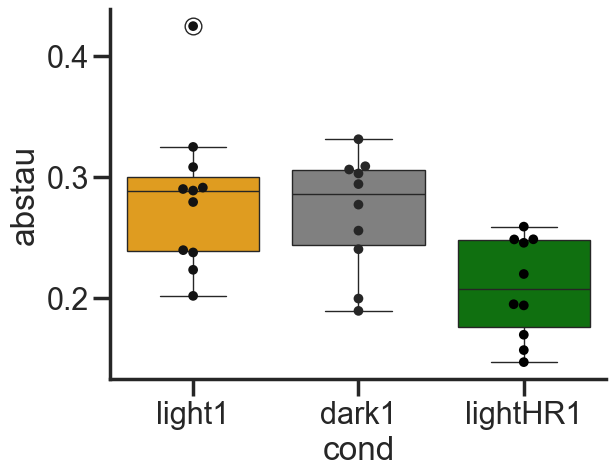

In [30]:
# f, ax = plt.subplots(figsize = (4, 4))

y = 'abstau'
coi = ['light1', 'dark1', 'lightHR1']
pal = ['orange', 'gray' , 'green']
# coi = ['dark1', 'darkHR1'];  pal = ['gray', 'brown']

_inp_plot = df_hr_taucorr[(df_hr_taucorr.tau > -1) 
                        & (df_hr_taucorr.run == 'all')
                        & (df_hr_taucorr.rec_id.isin(good_corr_sess))
                        & (df_hr_taucorr.cond.isin(coi))
                        & (df_hr_taucorr.hdc_pair == '1_1')].groupby(['cond', 'rec_id']).mean(numeric_only=True).reset_index()

# _inp_plot2 = _inp_plot.pivot(index = ['rec_id', 'pair'], columns = 'run', values = 'tau').dropna().reset_index()
sns.swarmplot(data = _inp_plot, x = 'cond', y = y,  dodge = False, hue = 'cond', order = coi,
             size = 7, palette='dark:k', legend = False)

sns.boxplot(data = _inp_plot, x = 'cond', y = y, order = coi,
        palette=pal)

# sns.boxplot(data = _inp_plot, x = 'cond', y = y,
#             hue = 'run', hue_order = ['stat', 'run'], palette=pal, )
# sns.swarmplot(data = _inp_plot, x = 'cond', y = y,  dodge = True, 
#               hue = 'run', hue_order = ['stat', 'run'], size = 7, color = 'k', legend = None)
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.savefig(f'box_hr_{coi}_{y}.pdf', transparent = True)  

In [32]:
(_inp_plot.groupby(['cond' ])[y].describe())

,count,mean,std,min,25%,50%,75%,max
cond,,,,,,,,
dark1,10.0,0.270678,0.048041,0.189615,0.244353,0.285767,0.305449,0.331256
light1,11.0,0.282788,0.060516,0.202002,0.238780,0.288881,0.299811,0.424583
lightHR1,10.0,0.208600,0.041566,0.147336,0.175973,0.207575,0.247880,0.259134


In [36]:
a1 = _inp_plot[(_inp_plot.cond == coi[0])][y].values
b1 = _inp_plot[(_inp_plot.cond == coi[1])][y].values
c1 = _inp_plot[(_inp_plot.cond == coi[2])][y].values


stat1, pval1 = stats.mannwhitneyu(a1, b1)
print(f'{coi[0]} vs {coi[1]} {stat1} {pval1}')
stat2, pval2 = stats.mannwhitneyu(a1, c1)
print(f'{coi[0]} vs {coi[2]} {stat2} {pval2}')
stat3, pval3 = stats.mannwhitneyu(b1, c1)
print(f'{coi[1]} vs {coi[2]} {stat3} {pval3}')

# pvals = [pval1, pval2, pval3]  
# print('Benjamini/Hochberg (non-negative)')
# multipletests(pvals, alpha=0.05, method='fdr_bh')

light1 vs dark1 55.0 1.0
light1 vs lightHR1 93.0 0.00827421565071521
dark1 vs lightHR1 83.0 0.014019277113959951


## Fig 2H

In [42]:
df_hr_taucorr.hdc_pair.unique()

array(['1_1'], dtype=object)

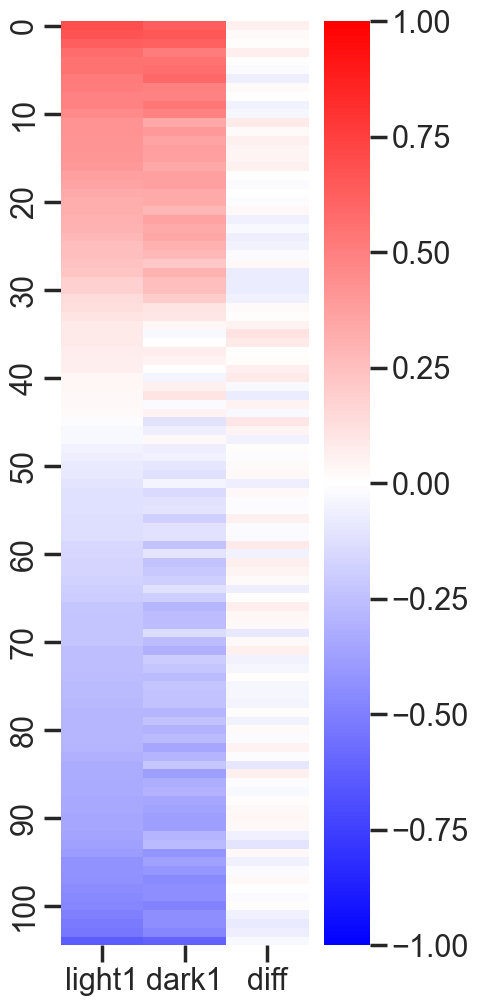

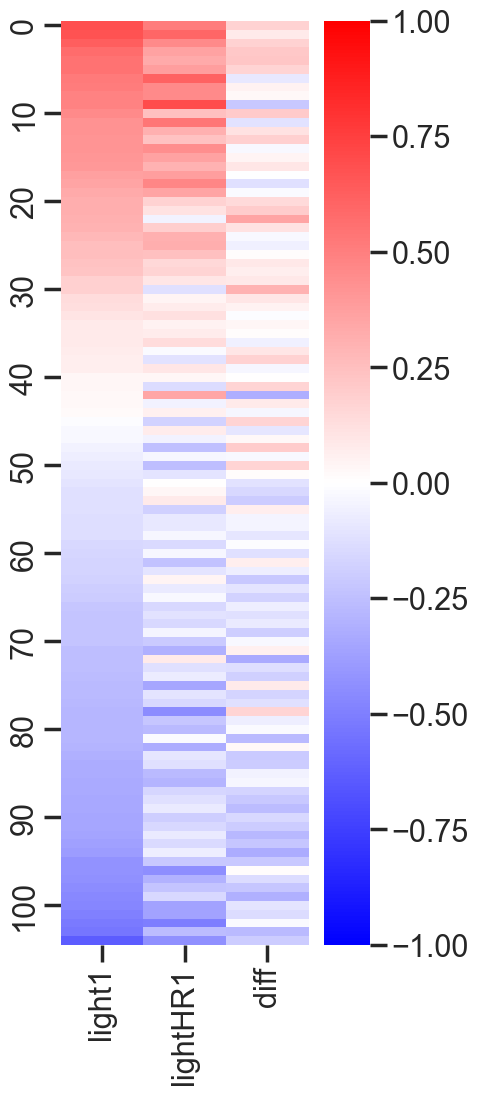

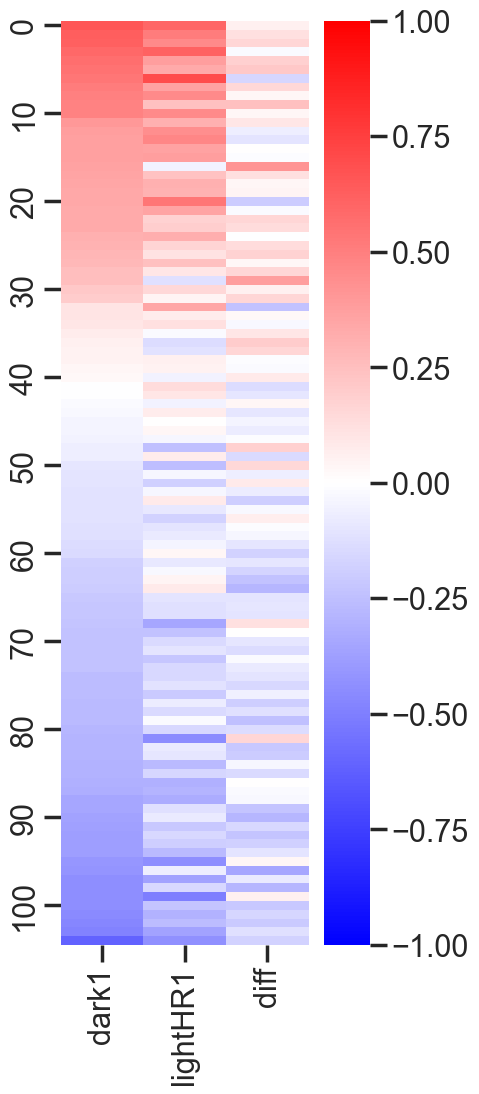

,rec_sess,tau1,tau2,pair_hdc,pear_r,pear_pval,n_pairs,diff_tau,abs_tau,cond,sign_sw
0,JA0144_20211207,-0.317085,-0.338688,1_1,0.934,0.0,21,0.021603,0.021603,light1_dark1,False
1,JA0144_20211207,-0.078906,-0.200278,1_1,0.934,0.0,21,0.121372,0.121372,light1_dark1,False
2,JA0144_20211207,0.181074,0.007049,1_1,0.934,0.0,21,0.174025,0.174025,light1_dark1,False
3,JA0144_20211207,-0.072838,-0.156013,1_1,0.934,0.0,21,0.083175,0.083175,light1_dark1,False
4,JA0144_20211207,0.001391,-0.178528,1_1,0.934,0.0,21,0.179919,0.179919,light1_dark1,True


In [46]:
ls = []
cond_pairs = [['light1', 'dark1'], ['light1', 'lightHR1'], 
              ['dark1', 'lightHR1'] ]
pair_hdc = ['1_1', '1_0', '0_0']

for pt in pair_hdc:
    for cp in cond_pairs:
        coi = cp
        _inp_plot = df_hr_taucorr[(df_hr_taucorr.cond.isin(coi)) 
                                 & (df_hr_taucorr.hdc_pair == pt) 
                                & (df_hr_taucorr.run == 'all')].pivot(index = ['rec_sess',
                             'pair'], columns = 'cond', values = 'tau').reset_index().dropna()

        for recs in _inp_plot.rec_sess.unique()[:]:
            # print(pt, cp, recs)
            tmp = _inp_plot[_inp_plot.rec_sess == recs]
            tau_arr = tmp[coi].values

            sign_corr = (np.sign(tau_arr)[:, 0] * np.sign(tau_arr)[:, 1]) < 0

        #     idx_sort = np.argsort(tau_arr[:, 0])
            diff_tau = tau_arr[:, 0] - tau_arr[:, 1]
            pear_r, p_val = stats.pearsonr(tau_arr[:, 0], tau_arr[:, 1])
            strong_pairs = abs(diff_tau) > 0.1
            sign_sw = sign_corr & strong_pairs
            abs_tau = abs(diff_tau)
            ls.append(pd.DataFrame({'rec_sess': recs, 'tau1': tau_arr[:, 0], 'tau2':tau_arr[:, 1], 'pair_hdc': pt,
                                    'pear_r': round(pear_r, 3), 'pear_pval': round(p_val, 3), 'n_pairs': tau_arr[:, 0].size, 
                  'diff_tau': diff_tau, 'abs_tau':abs_tau, 'cond': coi[0] + '_' + coi[1], 'sign_sw': sign_sw })) 
      
            
            if tau_arr.shape[0] > 100 and tau_arr.shape[0] < 200:
                if tau_arr.shape[0] > 100:
                    f, ax = plt.subplots(figsize = (4, 12))
                else:
                    f, ax = plt.subplots(figsize = (4, 6))
    
                out = np.vstack((tau_arr.T, diff_tau))
                out_df = pd.DataFrame(out.T, columns = [coi[0], coi[1], 'diff'])
                out_df = out_df.sort_values(by = coi[0], ascending=False).reset_index(drop = True)
                sns.heatmap(out_df, cmap = 'bwr', vmin = -1, vmax = 1, yticklabels = 10)
    
                plt.show()
    #         plt.savefig(f'heatmap_nhdc_pearson_{cp}.pdf', transparent=True)
        #     break
        # break
    
df_hr_delta_tau = pd.concat(ls)
df_hr_delta_tau.head()

## Fig 2J

/var/folders/v_/w_hl5qyx6gddpt2_xpcbzbrm0000gn/T/ipykernel_22451/3384073650.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = _inp_plot, x = 'cond', y = y, order = coi,


<Axes: xlabel='cond', ylabel='abs_tau'>

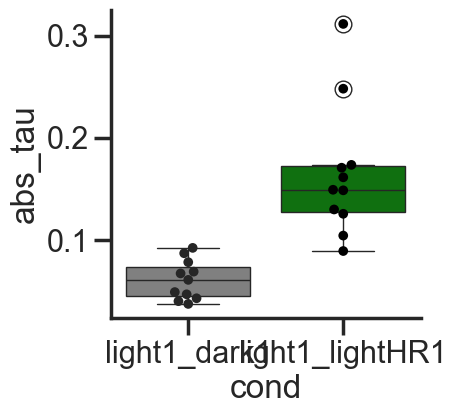

In [48]:
f, ax = plt.subplots(figsize = (4, 4))

y = 'abs_tau'
coi = ['light1_dark1', 'light1_lightHR1']
pal = ['gray', 'green']

_inp_plot = df_hr_delta_tau[(df_hr_delta_tau.cond.isin(coi))].groupby(['cond', 
                                                    'rec_sess']).mean(numeric_only = True).reset_index()
# _inp_plot2 = _inp_plot.pivot(index = ['rec_id', 'pair'], columns = 'run', values = 'tau').dropna().reset_index()
sns.swarmplot(data = _inp_plot, x = 'cond', y = y,  dodge = False, hue = 'cond', order = coi,
             size = 7, palette='dark:k', legend = False)

sns.boxplot(data = _inp_plot, x = 'cond', y = y, order = coi,
        palette=pal)

# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.savefig(f'box_hr_{coi}_delta_{y}.pdf', transparent = True)  

In [49]:
(_inp_plot.groupby(['cond' ])[y].describe())

,count,mean,std,min,25%,50%,75%,max
cond,,,,,,,,
light1_dark1,11.0,0.061034,0.019292,0.037439,0.044901,0.060984,0.073677,0.092306
light1_lightHR1,11.0,0.164773,0.064212,0.089228,0.127799,0.149202,0.172177,0.311572


In [50]:
a1 = _inp_plot[(_inp_plot.cond == coi[0])][y].values
b1 = _inp_plot[(_inp_plot.cond == coi[1])][y].values

stat, pval = stats.mannwhitneyu(a1, b1)
print(f'{coi[0]} vs {coi[1]} {stat} {pval}')


light1_dark1 vs light1_lightHR1 1.0 0.00010695988268558165


## Fig 2K: HD manifold for head restrainer (HR) cond

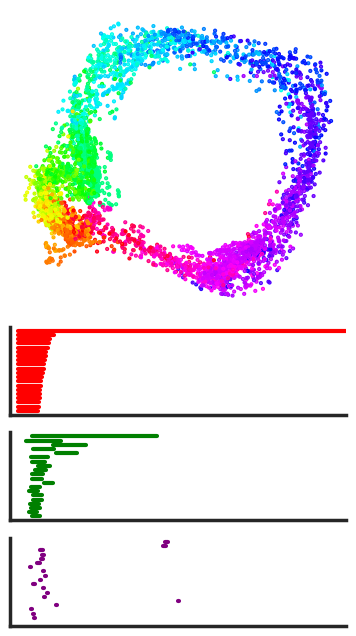

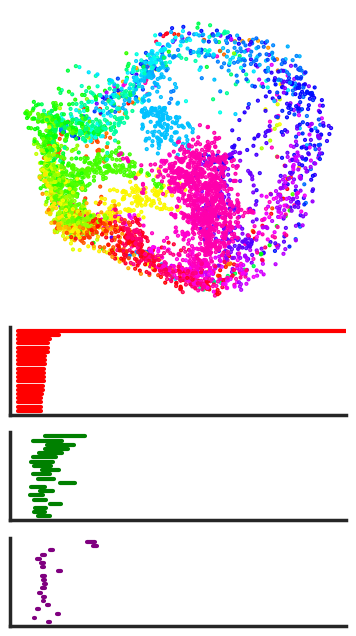

,rec_id,cond,dts,mouse_id,epoch,h1_bar,dec_err,rec_session,off_manifold_index
0,20211207_JA0144_light1,light1,20211207,JA0144,full,6.151794,25.458207,JA0144_20211207,0.353125
0,20220126_JA0153_light1,light1,20220126,JA0153,full,15.218874,25.684499,JA0153_20220126,0.165000
0,20220126_JA0153_lightHR1,lightHR1,20220126,JA0153,full,4.849484,31.401931,JA0153_20220126,0.429583
0,20220302_JA0162_light1,light1,20220302,JA0162,full,15.419246,16.881288,JA0162_20220302,0.120625
0,20220302_JA0162_lightHR1,lightHR1,20220302,JA0162,full,17.937344,15.546799,JA0162_20220302,0.523750


In [19]:
col_list = ['red', 'green', 'purple']
coi = ['light1', 'lightHR1']
angles = np.arange(0, 380, 20)
h1_bar_max = 40
ls = []

for k in d_hr_emb.keys():

    dts, mouse_id, cond = k.split('_')[-3:]
    if 'light' not in k:
        continue


    rec_session = mouse_id + '_' + dts

    tmp = d_hr_emb[k]
    isomap = tmp['isomap']
    measured_yaw = tmp['measured_yaw']
    isomap_yaw, dec_err, _ = decode_az_isomap(isomap[:, 0], isomap[:, 1], measured_yaw[:])
    lin_speed = tmp['lin_vel']
    h1_bar = tmp['h1_bar']

    # compute off manifold ratios
    _, rad_manifold = compute_radius(isomap[:,0], isomap[:,1])

    r90  = np.percentile(rad_manifold, 90)
    threshold = (r90 - 0.3*r90)

    off_ring = rad_manifold < threshold
    off_ring_ratio = np.sum(off_ring)/rad_manifold.size
    
    # print(f'{k}')
    # print(f'H1 bar length {h1_bar} dec err {dec_err}')
    # print(f'off_manifold_index {off_ring_ratio}')

    if '20220126_JA0153' in k:
        fig = plt.figure(figsize=(12, 8))
        gs = gridspec.GridSpec(6, 8)
        ax = fig.add_subplot(gs[0:3, 0:3])
        ax.scatter(isomap[:,0], isomap[:,1], s = 1, c = measured_yaw[:], 
                                               vmin = -180, vmax = 180, cmap = 'hsv')
        ax.axis('off')
        # ax.set_xlim(-40, 40)
        # ax.set_ylim(-40, 40)
        plt.xticks([])
    
        h0 = tmp['h0']
        h1 = tmp['h1']
        h2 = tmp['h2']    
        to_plot, h1_bar_run = get_long_bettibars(h0, h1, h2)
        
        for curr_betti, curr_bar in enumerate(to_plot):
            ax = fig.add_subplot(gs[curr_betti +3: curr_betti + 4, :3])
            for i, interval in enumerate((curr_bar)):
                ax.plot([interval[0], interval[1]], [i, i], color=col_list[curr_betti], lw=3)
            ax.set_xlim([-1, 40])
            plt.xticks([])
            plt.yticks([])
        plt.show()
    
    tmp_df = pd.DataFrame({'rec_id': k,  'cond': cond,  'dts': dts, 'mouse_id': mouse_id,
                       'epoch': 'full', 'h1_bar': h1_bar, 'dec_err': dec_err, 'rec_session':rec_session,
                       'off_manifold_index': off_ring_ratio}, index = [0])
    ls.append(tmp_df)    
    
    # break
    
    
df_hr_betti_2 = pd.concat(ls)
df_hr_betti_2.head()

## Figure 2L

/var/folders/v_/w_hl5qyx6gddpt2_xpcbzbrm0000gn/T/ipykernel_22451/820393811.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = _inp_plot, x = 'cond', y = y, palette=pal)


<Axes: xlabel='cond', ylabel='off_manifold_index'>

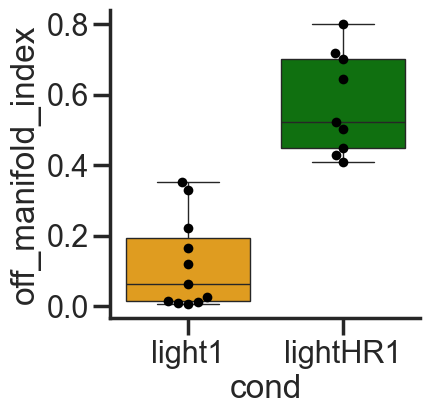

In [23]:
f, ax  = plt.subplots(figsize = (4, 4))

_inp_plot = df_hr_betti_2
y = 'off_manifold_index'
pal = ['orange', 'green']
sns.boxplot(data = _inp_plot, x = 'cond', y = y, palette=pal)
sns.swarmplot(data = _inp_plot, x = 'cond', y = y, size = 7, 
              palette = 'dark:k', dodge = True, legend = False)

# plt.savefig(f'HR_boxplot_{y}_full.pdf', transparent = True)

In [24]:
_inp_plot.groupby('cond')[y].describe()

,count,mean,std,min,25%,50%,75%,max
cond,,,,,,,,
light1,11.0,0.120170,0.130621,0.006250,0.014063,0.063125,0.192917,0.353125
lightHR1,9.0,0.575796,0.143445,0.409167,0.449792,0.523750,0.701458,0.801055


In [25]:
a1 = _inp_plot[(_inp_plot.cond == 'light1')][y].values
b1 = _inp_plot[(_inp_plot.cond == 'lightHR1')][y].values

stat, pval = stats.mannwhitneyu(a1, b1)
print(f'{coi[0]} vs {coi[1]} {stat} {pval}')


light1 vs lightHR1 0.0 0.00019709416773215247


## Fig 3F: HD manifold during HR stat vs run

20211207_JA0144_light1, # of hdc 10
20220126_JA0153_light1, # of hdc 18
stat 14.210235595703125
run 15.542181611061096


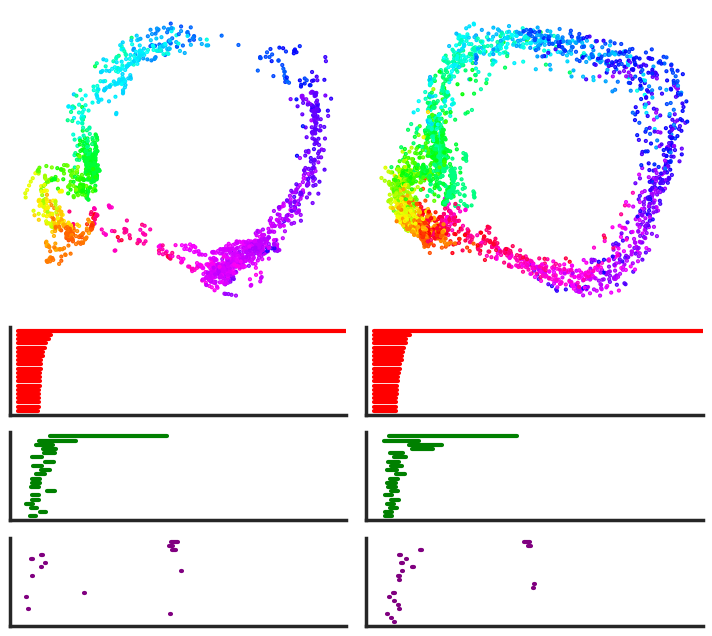

20220126_JA0153_lightHR1, # of hdc 21
stat 5.941466569900513
run 10.591240048408508


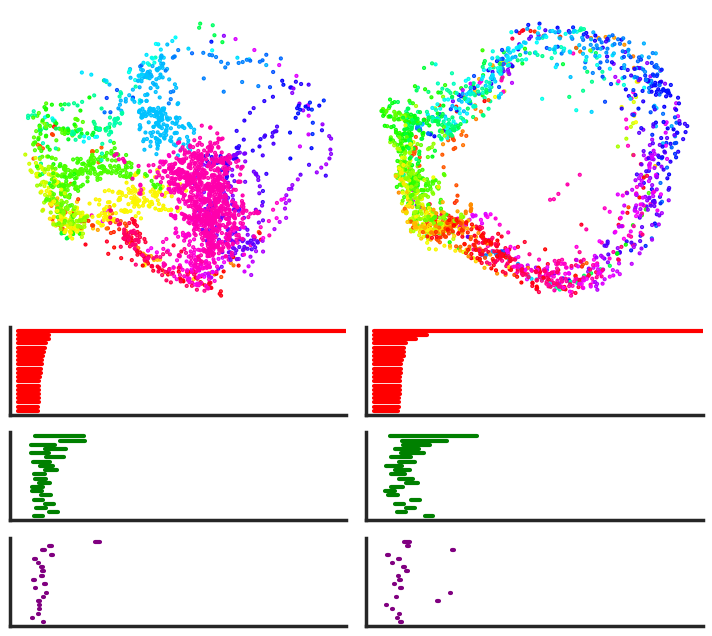

20220302_JA0162_light1, # of hdc 11
20220302_JA0162_lightHR1, # of hdc 10
20220419_JA0164_light1, # of hdc 11
20220419_JA0164_lightHR1, # of hdc 10
20220819_JA0178_light1, # of hdc 30
20220819_JA0178_lightHR1, # of hdc 30
20220822_JA0178_light1, # of hdc 27
20220822_JA0178_lightHR1, # of hdc 27
20220906_JA0178_light1, # of hdc 11
20220812_JA0181_light1, # of hdc 17
20220812_JA0181_lightHR1, # of hdc 18
20220815_JA0181_light1, # of hdc 16
20220815_JA0181_lightHR1, # of hdc 16
20220818_JA0181_light1, # of hdc 14
20220818_JA0181_lightHR1, # of hdc 14
20220712_MC022_light1, # of hdc 41
20220712_MC022_lightHR1, # of hdc 41


,rec_id,cond,dts,animal_name,az_occ,run,h1_bar,dec_err,rec_session,stat_off_manifold,run_ratio
0,20211207_JA0144_light1,light1,20211207,JA0144,0.916667,stat,5.956747,27.552,JA0144_20211207,0.155352,0.659375
0,20211207_JA0144_light1,light1,20211207,JA0144,1.000000,locom,6.397861,24.376,JA0144_20211207,0.155352,0.659375
0,20220126_JA0153_light1,light1,20220126,JA0153,0.916667,stat,14.210236,22.769,JA0153_20220126,0.179570,0.612500
0,20220126_JA0153_light1,light1,20220126,JA0153,1.000000,locom,15.542182,27.529,JA0153_20220126,0.179570,0.612500
0,20220126_JA0153_lightHR1,lightHR1,20220126,JA0153,0.944444,stat,5.941467,28.507,JA0153_20220126,0.625000,0.433333


In [128]:
col_list = ['red', 'green', 'purple']
angles = np.arange(-180, 200, 20)
h1_bar_max = 40
ls = []

for k in d_hr_emb.keys():
    dts, animal_name, cond = k.split('_')[-3:]
    if 'light' not in k:
        continue

    rec_session = animal_name + '_' + dts
    tmp = d_hr_emb[k]
    isomap = tmp['isomap']
    measured_yaw = tmp['measured_yaw']
    lin_vel = tmp['lin_vel']
    n_hdc = tmp['n_hdc']
    stat_az_occ = tmp['stat_az_occ'] 
    run_az_occ = tmp['run_az_occ'] 
    
    print(f'{k}, # of hdc {n_hdc}')
    if n_hdc < 10:
        continue
    stat_idx, run_idx = tmp['stat_idx'], tmp['run_idx']
#     try:
#         stat_idx, run_idx = get_stat_run_epochs(lin_vel, window_size=5, speed_thr = 6)
#     except Exception as e:
#         print (e)
#         continue 
        
    stat_dec_err, loc_dec_err = tmp['stat']['dec_err'], tmp['run']['dec_err']
    run_ratio = run_idx.size/lin_vel.size
    
    # 10 samples = 1s
#     occup, _ = np.histogram(measured_yaw[stat_idx], bins = angles)
#     stat_az_occ = occup[occup > 10].size/occup.size
#     occup, _ = np.histogram(measured_yaw[run_idx], bins = angles)
#     run_az_occ = occup[occup > 10].size/occup.size
    # compute off manifold ratios
    _, rad_manifold = compute_radius(isomap[:,0], isomap[:,1])
    _, rad_manifold_stat = compute_radius(isomap[stat_idx,0], isomap[stat_idx,1])
    _, rad_manifold_loc = compute_radius(isomap[run_idx,0], isomap[run_idx,1])
    offmanifold_threshold = np.percentile(rad_manifold_loc, 10)
    stat_off_manifold = np.sum(rad_manifold_stat < offmanifold_threshold)/rad_manifold_stat.size
    
    
    # print(f'dec err stat:{stat_dec_err}, run:{loc_dec_err}')
    # print(f'az occ stat:{stat_az_occ}, run:{run_az_occ}, off-manifold index {stat_off_manifold}')
    
    if '20220126_JA0153' in k:
        fig = plt.figure(figsize=(12, 8))
        gs = gridspec.GridSpec(6, 8)
        ax = fig.add_subplot(gs[0:3, 0:3])
        ax.scatter(isomap[stat_idx,0], isomap[stat_idx,1], s = 1, c = measured_yaw[stat_idx], 
                                               vmin = -180, vmax = 180, cmap = 'hsv')
        ax.axis('off')
        plt.xticks([])
        # ax.set_xlim(-40, 40)
        # ax.set_ylim(-40, 40)
        #         plt.yticks([])
        ax = fig.add_subplot(gs[0:3, 3:6])
        ax.scatter(isomap[run_idx,0], isomap[run_idx,1], s = 1, c = measured_yaw[run_idx], 
                                               vmin = -180, vmax = 180, cmap = 'hsv')
        ax.axis('off')
        plt.xticks([])
        # ax.set_xlim(-40, 40)
        # ax.set_ylim(-40, 40)
        
        h0 = tmp['stat']['h0']
        h1 = tmp['stat']['h1']
        h2 = tmp['stat']['h2']
    
        to_plot, h1_bar_stat = get_long_bettibars(h0, h1, h2)
        print('stat', h1_bar_stat)
        for curr_betti, curr_bar in enumerate(to_plot):
            ax = fig.add_subplot(gs[curr_betti +3: curr_betti + 4, :3])
            for i, interval in enumerate((curr_bar)):
                ax.plot([interval[0], interval[1]], [i, i], color=col_list[curr_betti], lw=3)
            ax.set_xlim([-1, 40])
            plt.xticks([])
            plt.yticks([])
    
        h0 = tmp['run']['h0']
        h1 = tmp['run']['h1']
        h2 = tmp['run']['h2']
        
        to_plot, h1_bar_run = get_long_bettibars(h0, h1, h2)
        print('run', h1_bar_run)
        for curr_betti, curr_bar in enumerate(to_plot):
            ax = fig.add_subplot(gs[curr_betti +3: curr_betti + 4, 3:6])
            for i, interval in enumerate((curr_bar)):
                ax.plot([interval[0], interval[1]], [i, i], color=col_list[curr_betti], lw=3)
            ax.set_xlim([-1, 40])
            plt.xticks([])
            plt.yticks([])
        plt.show()
    # break
    tmp_df = pd.DataFrame({'rec_id': k,  'cond': cond,  'dts': dts, 'animal_name': animal_name, 'az_occ':stat_az_occ,
                           'run': 'stat', 'h1_bar': tmp['stat']['h1_bar'], 'dec_err': stat_dec_err, 'rec_session':rec_session,
                          'stat_off_manifold': stat_off_manifold, 'run_ratio': run_ratio}, index = [0])
    ls.append(tmp_df)

    tmp_df = pd.DataFrame({'rec_id': k, 'cond': cond, 'dts': dts, 'animal_name': animal_name, 'az_occ':run_az_occ, 
                           'run': 'locom', 'h1_bar': tmp['run']['h1_bar'], 'dec_err': loc_dec_err, 'rec_session':rec_session,
                          'stat_off_manifold': stat_off_manifold, 'run_ratio': run_ratio}, index = [0])
    ls.append(tmp_df)
    
df_hr_betti_run = pd.concat(ls)
df_hr_betti_run.head()


### Fig 3G

<Axes: xlabel='cond', ylabel='h1_bar'>

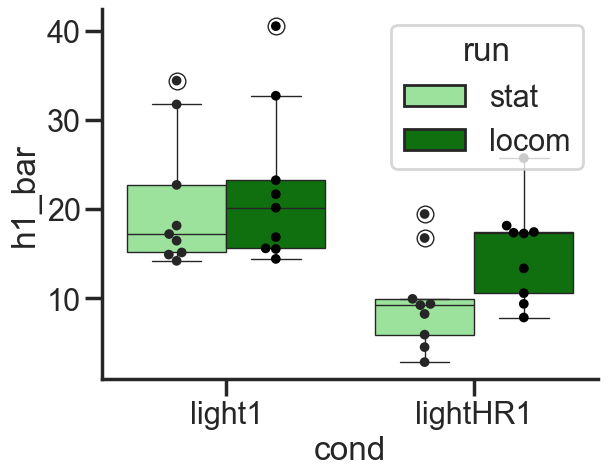

In [70]:
coi = ['light1', 'lightHR1']
_inp_plot = df_hr_betti_run[df_hr_betti_run.rec_session.isin(good_sess)]
pal = ['lightgreen', 'green',  ]

y = 'h1_bar'
sns.boxplot(data = _inp_plot, x = 'cond', y = y, hue = 'run', 
            palette= pal)
sns.swarmplot(data = _inp_plot, x = 'cond', y = y, hue = 'run', palette = 'dark:k', size = 7,
              dodge = True, legend = False)

# plt.savefig(f'box_hr_run_betti_{coi}_{y}.pdf', transparent = True)  

In [71]:
_inp_plot.groupby(['cond', 'run'])[y].describe()

count       mean       std        min        25%        50%  \
cond     run                                                                  
light1   locom    9.0  22.303528  8.855579  14.425529  15.609478  20.162482   
         stat     9.0  20.550775  7.551500  14.210236  15.150577  17.210920   
lightHR1 locom    9.0  15.239635  5.539396   7.862246  10.591240  17.274356   
         stat     9.0   9.601844  5.418126   2.865592   5.941467   9.248994   

                      75%        max  
cond     run                          
light1   locom  23.243962  40.502560  
         stat   22.717576  34.398533  
lightHR1 locom  17.439497  25.718766  
         stat    9.951374  19.455693

In [72]:
a1 = _inp_plot[(_inp_plot.run == 'stat') & (_inp_plot['cond'] == coi[0])][y].values
a2 = _inp_plot[(_inp_plot.run == 'locom') & (_inp_plot['cond'] == coi[0])][y].values
b1 = _inp_plot[(_inp_plot.run == 'stat') & (_inp_plot['cond'] == coi[1])][y].values
b2 = _inp_plot[(_inp_plot.run == 'locom') & (_inp_plot['cond'] == coi[1])][y].values

stat1, pval1 = stats.wilcoxon(a1, a2)
print(f'{coi[0]} stat vs run {stat1} {pval1}')
stat2, pval2 = stats.wilcoxon(b1, b2)
print(f'{coi[1]} stat vs run {stat2} {pval2}')
stat3, pval3 = stats.mannwhitneyu(a1, b1)
print(f'stat  {stat3} {pval3}')
stat4, pval4 = stats.mannwhitneyu(a2, b2)
print(f'run {stat4} {pval4}')
pvals = [pval1, pval2, pval3, pval4]  
print('Benjamini/Hochberg (non-negative)')
print(multipletests(pvals, alpha=0.05, method='fdr_bh'))

light1 stat vs run 9.0 0.12890625
lightHR1 stat vs run 0.0 0.00390625
stat  71.0 0.008071487425268007
run 58.0 0.13332021558962742
Benjamini/Hochberg (non-negative)
(array([False,  True,  True, False]), array([0.13332022, 0.015625  , 0.01614297, 0.13332022]), np.float64(0.012741455098566168), 0.0125)


## Fig 3H

In [76]:
df_hr_taucorr.head()

,pair,tau,pval,rec_id,dts,cond,hdc_pair,run,animal_name,n_hdc,rec_sess,abstau
0,"(25.0, 51.0)",-0.200876,8.440973e-277,20211207_JA0144_dark1,20211207,dark1,1_1,all,JA0144,8,JA0144_20211207,0.200876
0,"(25.0, 51.0)",-0.239519,1.527409e-141,20211207_JA0144_dark1,20211207,dark1,1_1,stat,JA0144,8,JA0144_20211207,0.239519
0,"(25.0, 51.0)",-0.183297,6.661943e-149,20211207_JA0144_dark1,20211207,dark1,1_1,run,JA0144,8,JA0144_20211207,0.183297
0,"(25.0, 62.0)",-0.014558,6.474542e-03,20211207_JA0144_dark1,20211207,dark1,1_1,all,JA0144,8,JA0144_20211207,0.014558
0,"(25.0, 62.0)",-0.042756,1.093612e-06,20211207_JA0144_dark1,20211207,dark1,1_1,stat,JA0144,8,JA0144_20211207,0.042756


In [114]:
coi = ['light1', 'lightHR1']
n_pairs = df_hr_taucorr[(df_hr_taucorr.tau > -1) 
                        & (df_hr_taucorr.run == 'stat')
                        # & (df_hr_taucorr.rec_sess.isin(hr_sess))
                        & (df_hr_taucorr.cond.isin(coi))
                        & (df_hr_taucorr.hdc_pair == '1_1')].groupby(['cond', 'rec_id'])['pair'].count().reset_index()
good_corr_sess = n_pairs[n_pairs.pair > 25].rec_id.unique()

<Axes: xlabel='cond', ylabel='abstau'>

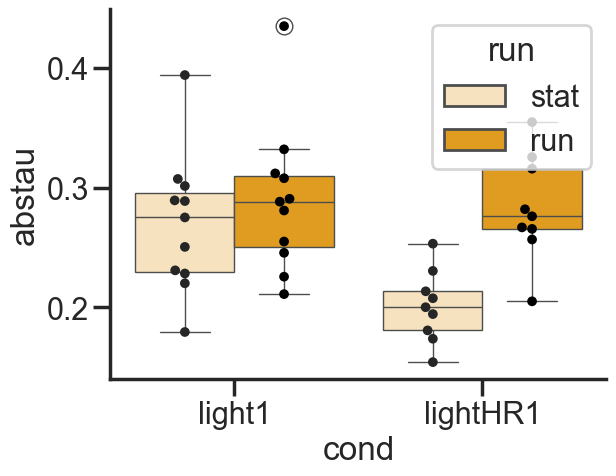

In [116]:
y = 'abstau'
coi = ['light1', 'lightHR1']
_inp_plot = df_hr_taucorr[(df_hr_taucorr.cond.isin(coi)) 
                    & (df_hr_taucorr.rec_id.isin(good_corr_sess))
                    & (df_hr_taucorr.run != 'all')].groupby(['cond', 
                                                   'rec_id', 'run']).mean(numeric_only=True).reset_index()

sns.boxplot(data = _inp_plot, x = 'cond', y = y, hue = 'run', hue_order = ['stat', 'run'],
            palette = pal)
sns.swarmplot(data = _inp_plot, x = 'cond', y = y, hue = 'run', hue_order = ['stat', 'run'], 
              palette = 'dark:k', size = 7,
              dodge = True, legend = False)

# plt.savefig(f'box_run_betti_{coi}_{y}.pdf', transparent = True)  

In [117]:
_inp_plot.groupby(['cond', 'run'])['abstau'].describe()

count      mean       std       min       25%       50%  \
cond     run                                                             
light1   run    11.0  0.289507  0.061069  0.211051  0.250305  0.288360   
         stat   11.0  0.269608  0.057375  0.179372  0.229604  0.275169   
lightHR1 run     9.0  0.283197  0.043946  0.205038  0.265588  0.276140   
         stat    9.0  0.200872  0.029963  0.154198  0.180720  0.200096   

                    75%       max  
cond     run                       
light1   run   0.309968  0.435124  
         stat  0.295443  0.394202  
lightHR1 run   0.315929  0.354915  
         stat  0.213420  0.253226

In [118]:
a1 = _inp_plot[(_inp_plot.run == 'stat') & (_inp_plot['cond'] == coi[0])][y].values
a2 = _inp_plot[(_inp_plot.run == 'run') & (_inp_plot['cond'] == coi[0])][y].values
b1 = _inp_plot[(_inp_plot.run == 'stat') & (_inp_plot['cond'] == coi[1])][y].values
b2 = _inp_plot[(_inp_plot.run == 'run') & (_inp_plot['cond'] == coi[1])][y].values

stat1, pval1 = stats.wilcoxon(a1, a2)
print(f'{coi[0]} stat vs run {stat1} {pval1}')
stat2, pval2 = stats.wilcoxon(b1, b2)
print(f'{coi[1]} stat vs run {stat2} {pval2}')
stat3, pval3 = stats.mannwhitneyu(a1, b1)
print(f'stat  {stat3} {pval3}')
stat4, pval4 = stats.mannwhitneyu(a2, b2)
print(f'run {stat4} {pval4}')
pvals = [pval1, pval2, pval3, pval4]  
print('Benjamini/Hochberg (non-negative)')
print(multipletests(pvals, alpha=0.05, method='fdr_bh'))

light1 stat vs run 6.0 0.013671875
lightHR1 stat vs run 0.0 0.00390625
stat  86.0 0.006237007458873189
run 50.0 1.0
Benjamini/Hochberg (non-negative)
(array([ True,  True,  True, False]), array([0.01822917, 0.01247401, 0.01247401, 1.        ]), np.float64(0.012741455098566168), 0.0125)


## Fig 3I

In [122]:
df_hr_betti_run.head()

,rec_id,cond,dts,animal_name,az_occ,run,h1_bar,dec_err,rec_session,stat_off_manifold,run_ratio
0,20211207_JA0144_light1,light1,20211207,JA0144,0.916667,stat,5.956747,27.552,JA0144_20211207,0.155352,0.659375
0,20211207_JA0144_light1,light1,20211207,JA0144,1.000000,locom,6.397861,24.376,JA0144_20211207,0.155352,0.659375
0,20220126_JA0153_light1,light1,20220126,JA0153,0.916667,stat,14.210236,22.769,JA0153_20220126,0.179570,0.612500
0,20220126_JA0153_light1,light1,20220126,JA0153,1.000000,locom,15.542182,27.529,JA0153_20220126,0.179570,0.612500
0,20220126_JA0153_lightHR1,lightHR1,20220126,JA0153,0.944444,stat,5.941467,28.507,JA0153_20220126,0.625000,0.433333


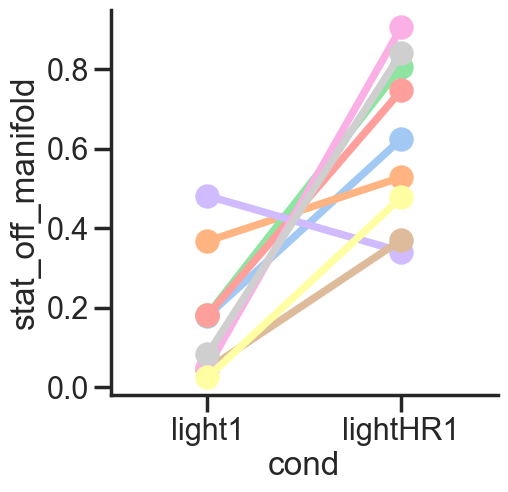

In [132]:
f, ax = plt.subplots(figsize = (5, 5))
y = 'stat_off_manifold'
coi = ['light1', 'lightHR1']
_inp_plot = df_hr_betti_run[df_hr_betti_run.cond.isin(coi) 
                     & (df_hr_betti_run.run == 'stat')
                     & (df_hr_betti_run.rec_session.isin(good_sess))
                    ]
sns.pointplot(data = _inp_plot, x = 'cond', y = y, hue = 'rec_session',
             order = coi)

# sns.barplot(data = _inp_plot, x = 'cond', y = y, errorbar= ('ci', 68), palette=pal)
# sns.swarmplot(data = _inp_plot, x = 'cond', y = y, color = 'k', size = 10)
plt.legend([],[], frameon=False)
# plt.savefig(f'point_{coi}_{y}.pdf', transparent = True) 

In [133]:
_inp_plot.groupby('cond')[y].describe()

,count,mean,std,min,25%,50%,75%,max
cond,,,,,,,,
light1,9.0,0.177382,0.155968,0.025105,0.050000,0.17957,0.181818,0.481818
lightHR1,9.0,0.627092,0.208712,0.341648,0.478295,0.62500,0.806061,0.905683


In [134]:
a1 = _inp_plot[_inp_plot.cond == coi[0]][y].values
b1 = _inp_plot[_inp_plot.cond == coi[1]][y].values
print(stats.mannwhitneyu(a1, b1))

MannwhitneyuResult(statistic=np.float64(4.0), pvalue=np.float64(0.0014784647972275093))


In [140]:
df_hr_betti_run.head()

,rec_id,cond,dts,animal_name,az_occ,run,h1_bar,dec_err,rec_session,stat_off_manifold,run_ratio
0,20211207_JA0144_light1,light1,20211207,JA0144,0.916667,stat,5.956747,27.552,JA0144_20211207,0.155352,0.659375
0,20211207_JA0144_light1,light1,20211207,JA0144,1.000000,locom,6.397861,24.376,JA0144_20211207,0.155352,0.659375
0,20220126_JA0153_light1,light1,20220126,JA0153,0.916667,stat,14.210236,22.769,JA0153_20220126,0.179570,0.612500
0,20220126_JA0153_light1,light1,20220126,JA0153,1.000000,locom,15.542182,27.529,JA0153_20220126,0.179570,0.612500
0,20220126_JA0153_lightHR1,lightHR1,20220126,JA0153,0.944444,stat,5.941467,28.507,JA0153_20220126,0.625000,0.433333


## Fig 3H

20211207_JA0144_light1


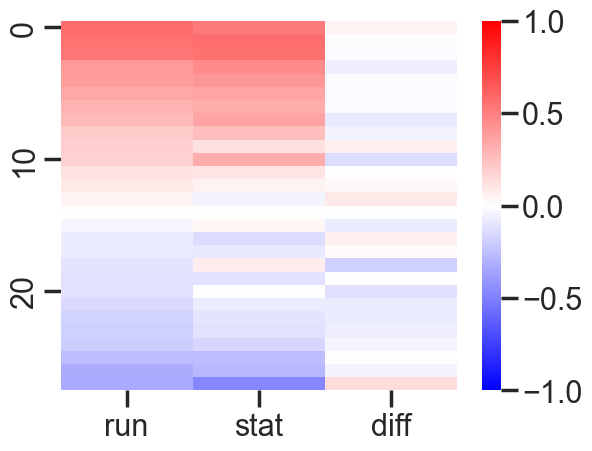

20211207_JA0144_lightHR1
20220126_JA0153_light1
20220126_JA0153_lightHR1
20220302_JA0162_light1


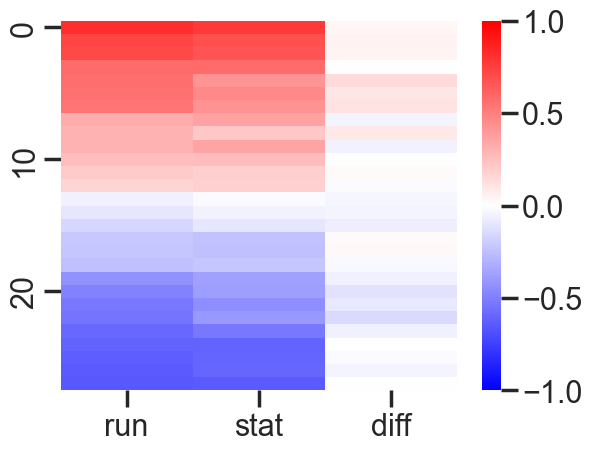

20220302_JA0162_lightHR1


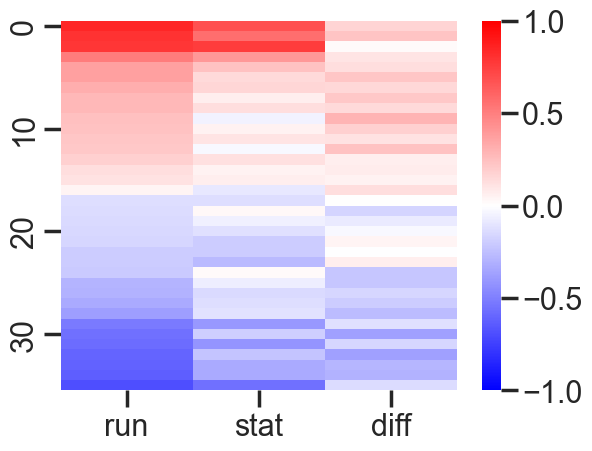

20220419_JA0164_light1


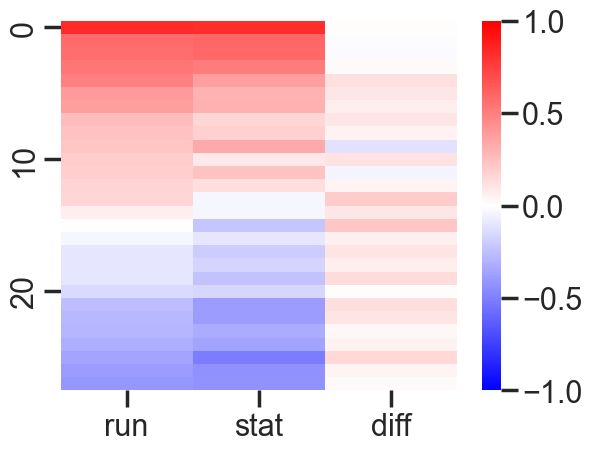

20220419_JA0164_lightHR1
20220819_JA0178_light1
20220819_JA0178_lightHR1
20220822_JA0178_light1
20220822_JA0178_lightHR1
20220824_JA0178_light1
20220824_JA0178_lightHR1
20220906_JA0178_light1
20220812_JA0181_light1
20220812_JA0181_lightHR1
20220815_JA0181_light1
20220815_JA0181_lightHR1
20220818_JA0181_light1
20220818_JA0181_lightHR1
20220712_MC022_light1
20220712_MC022_lightHR1
20220829_MC038_lightHR1


,rec_id,animal_name,cond,dts,delta_all,delta_pos,pear_r_pos,pos_n,neg_n,delta_neg,pear_r_neg,pear_r_all
0,20211207_JA0144_light1,JA0144,light1,20211207,0.056253,-0.012751,0.958,15,13,-0.033228,0.843,0.968
0,20211207_JA0144_lightHR1,JA0144,lightHR1,20211207,0.177548,0.062472,0.891,5,10,-0.193878,-0.384,0.436
0,20220126_JA0153_light1,JA0153,light1,20220126,0.116739,0.095614,0.869,52,26,-0.019798,0.628,0.883
0,20220126_JA0153_lightHR1,JA0153,lightHR1,20220126,0.150322,0.178652,0.773,108,63,-0.048160,0.715,0.883
0,20220302_JA0162_light1,JA0162,light1,20220302,0.052282,0.037246,0.960,13,15,-0.044108,0.975,0.994


In [157]:
ls = []
for rec in df_hr_taucorr.rec_id.unique():
    if 'light' not in rec:
        continue
    print(rec)
    dts, animal_name, cond = rec.split('_')[-3:]
    tmp_tau_arr = df_hr_taucorr[(df_hr_taucorr.rec_id == rec)].pivot(index = 'pair',
                                       columns = 'run', values = 'tau')[['run', 'stat']].values
    diff_tau = tmp_tau_arr[:, 0] - tmp_tau_arr[:, 1]
    loc_pos = tmp_tau_arr[:, 0] > 0
    loc_neg = tmp_tau_arr[:, 0] < 0
    if sum(loc_pos) < 5 or sum(loc_neg) < 5:
        continue
    delta_pos = np.mean((tmp_tau_arr[loc_pos, 0] - tmp_tau_arr[loc_pos, 1]))
    delta_neg = np.mean((tmp_tau_arr[loc_neg, 0] - tmp_tau_arr[loc_neg, 1]))
    delta_all = np.mean(abs(tmp_tau_arr[:, 0] - tmp_tau_arr[:, 1]))
    
    pear_r_pos, pval = stats.pearsonr(tmp_tau_arr[loc_pos, 0], tmp_tau_arr[loc_pos, 1])
    pear_r_neg, pval = stats.pearsonr(tmp_tau_arr[loc_neg, 0], tmp_tau_arr[loc_neg, 1])
    pear_r_all, pval = stats.pearsonr(tmp_tau_arr[:, 0], tmp_tau_arr[:, 1])
            
    tmp_df = pd.DataFrame({
        'rec_id': rec, 'animal_name': animal_name, 'cond': cond,  'dts':dts, 'delta_all':delta_all,
        'delta_pos':delta_pos, 'pear_r_pos': round(pear_r_pos, 3), 'pos_n': loc_pos.sum(), 'neg_n': loc_neg.sum(),
        'delta_neg':delta_neg, 'pear_r_neg': round(pear_r_neg, 3), 'pear_r_all': round(pear_r_all, 3)}, index = [0]
                         )    
    ls.append(tmp_df)
    
    out = np.vstack((tmp_tau_arr.T, diff_tau))
    if out.shape[1] > 25 and out.shape[1] < 40:
        out_df = pd.DataFrame(out.T, columns = ['run', 'stat', 'diff'])
        out_df = out_df.sort_values(by = 'run', ascending=False).reset_index(drop = True)
        sns.heatmap(out_df, cmap = 'bwr', vmin = -1, vmax = 1, yticklabels = 10)
        plt.show()
    # break
df_hr_delta_tau_run = pd.concat(ls)
df_hr_delta_tau_run.head()

In [156]:
df_hr_delta_tau_run.head()

,rec_id,animal_name,cond,dts,delta_all,delta_pos,pear_r_pos,pos_n,neg_n,delta_neg,pear_r_neg,pear_r_all
0,20211207_JA0144_dark1,JA0144,dark1,20211207,0.059660,0.016909,0.944,14,14,-0.013682,0.704,0.957
0,20211207_JA0144_darkHR1,JA0144,darkHR1,20211207,0.118528,0.043866,0.765,7,8,-0.048345,0.527,0.825
0,20211207_JA0144_light1,JA0144,light1,20211207,0.056253,-0.012751,0.958,15,13,-0.033228,0.843,0.968
0,20211207_JA0144_lightHR1,JA0144,lightHR1,20211207,0.177548,0.062472,0.891,5,10,-0.193878,-0.384,0.436
0,20220126_JA0153_dark1,JA0153,dark1,20220126,0.187166,0.144013,0.829,26,19,-0.143307,-0.058,0.725


In [166]:
d_hr_offman = dict(zip(df_hr_betti_run[df_hr_betti_run.run == 'stat'].rec_id.values, 
                       df_hr_betti_run[df_hr_betti_run.run == 'stat'].stat_off_manifold.values))
df_hr_delta_tau_run['stat_off_manifold'] = df_hr_delta_tau_run.rec_id.map(d_hr_offman)
df_hr_delta_tau_run['rec_session'] = df_hr_delta_tau_run.animal_name + '_' + df_hr_delta_tau_run.dts

In [167]:
df_hr_delta_tau_run.head()

,rec_id,animal_name,cond,dts,delta_all,delta_pos,pear_r_pos,pos_n,neg_n,delta_neg,pear_r_neg,pear_r_all,stat_off_manifold,rec_session
0,20211207_JA0144_light1,JA0144,light1,20211207,0.056253,-0.012751,0.958,15,13,-0.033228,0.843,0.968,0.155352,JA0144_20211207
0,20211207_JA0144_lightHR1,JA0144,lightHR1,20211207,0.177548,0.062472,0.891,5,10,-0.193878,-0.384,0.436,NaN,JA0144_20211207
0,20220126_JA0153_light1,JA0153,light1,20220126,0.116739,0.095614,0.869,52,26,-0.019798,0.628,0.883,0.179570,JA0153_20220126
0,20220126_JA0153_lightHR1,JA0153,lightHR1,20220126,0.150322,0.178652,0.773,108,63,-0.048160,0.715,0.883,0.625000,JA0153_20220126
0,20220302_JA0162_light1,JA0162,light1,20220302,0.052282,0.037246,0.960,13,15,-0.044108,0.975,0.994,0.367918,JA0162_20220302


## Fig 3J

L1 PearsonRResult(statistic=np.float64(0.15875226441742893), pvalue=np.float64(0.6833079155599018))
HR PearsonRResult(statistic=np.float64(0.6770834513238242), pvalue=np.float64(0.04513683211746637))


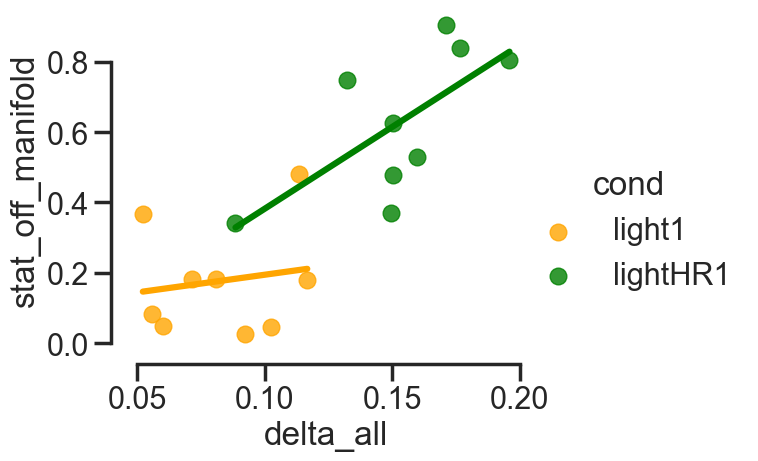

In [168]:
coi = ['light1', 'lightHR1']; pal = ['orange', 'green']
# coi = ['dark1', 'darkHR1'];  pal = ['gray', 'brown']

_inp_plot = df_hr_delta_tau_run[df_hr_delta_tau_run.rec_session.isin(good_sess)
                        & (df_hr_delta_tau_run.cond.isin(coi))
                        ]
# _inp_plot = df_delta_tau.dropna()
x, y = 'delta_all', 'stat_off_manifold'


sns.lmplot(data = _inp_plot, x = x, y = y, hue = 'cond', palette=pal,
           hue_order = coi, 
           aspect = 1.2, ci=None)

a1 = _inp_plot[(_inp_plot.cond == coi[0])][x].values
a2 = _inp_plot[(_inp_plot.cond == coi[0])][y].values
b1 = _inp_plot[(_inp_plot.cond == coi[1])][x].values
b2 = _inp_plot[(_inp_plot.cond == coi[1])][y].values

print('L1', stats.pearsonr(a1, a2))
print('HR', stats.pearsonr(b1, b2))
sns.despine(offset=10, trim=True)

# plt.savefig(f'lmplot_hr_{coi}_{x}_{y}.pdf', transparent = True)